In [1]:
#We need to install tf version 2.15 for compatibility with this notebook (written in March 2024).
!pip uninstall tensorflow
!pip install tensorflow==2.15.0
!tensorflow --version

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
  Att

# Transfer Learning with TensorFlow Part 2 - Fine Tuning #

In previous notebook we covered transfer learning feature extraction.  Now it's time to learn about a new kind of transfer learning - fine tuning.  

In [2]:
#Check if using a GPU
!nvidia-smi

Fri Nov  8 04:33:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks we have created a bunch of helper functions.  We could rewrite them all, but that would be tedious.

So it's a good idea to put functions you will use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py



In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-11-08 04:33:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-11-08 04:33:58 (22.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
#Import helper functions we will use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

> ** 🔑 Note: ** If you're running this function in Google Colab, when it times out Google will delete 'helper_functions.py' so you'll have to redownload it if you want access to your helper functions.

### Let's get some data ###

This time we will see how we can use the pre-trained models within tf.keras.applications and apply them to our own problems, recognizing images of food.  Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications



In [5]:
# Get 10% of training data of 10 Classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-11-08 04:34:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   156MB/s    in 1.0s    

2024-11-08 04:34:11 (156 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
#Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [7]:
#Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMAGE_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
#Check out the class names of our data
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.53583069e+02 2.52811234e+02 2.55000000e+02]
   [2.54953918e+02 2.54953918e+02 2.50640610e+02]
   [2.53506866e+02 2.55000000e+02 2.36502380e+02]
   ...
   [3.69376945e+01 2.49376945e+01 4.83570786e+01]
   [3.14100342e+01 1.74100342e+01 4.30090370e+01]
   [2.42833767e+01 1.04101439e+01 3.38591995e+01]]

  [[2.54893661e+02 2.54601242e+02 2.52296082e+02]
   [2.55000000e+02 2.55000000e+02 2.52990753e+02]
   [2.52534439e+02 2.54799591e+02 2.42316483e+02]
   ...
   [3.32142639e+01 2.14285278e+01 4.22416153e+01]
   [3.09932899e+01 1.71248398e+01 3.97209435e+01]
   [2.54603157e+01 1.24834366e+01 3.03493423e+01]]

  [[2.53578445e+02 2.54774551e+02 2.44685425e+02]
   [2.54280777e+02 2.55000000e+02 2.52857147e+02]
   [2.50450897e+02 2.55000000e+02 2.45359207e+02]
   ...
   [3.41547775e+01 2.28116760e+01 3.97969170e+01]
   [3.18178883e+01 1.88732224e+01 3.63513412e+01]
   [2.15332718e+01 7.83924294e+00 2.14994545e+01]]

  ...

  [[1.62729828e+02 1.79729828e+02 1.60729828e+02]
   [1

# Model 0: Building a transfer learning model using keras functional API
The sequential API is straightforward, it runs our layers in sequential oder.

But the functional API gives us more flexibility with our models.  

In [12]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

#3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

#4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNets)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

#6. Average pool the outputs of the base model (aggregate all the mode important information)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

#8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

#9. Compile the model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

#10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                        batch_size=BATCH_SIZE,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=len(test_data))

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/5
24/24 [==============================] - 22s 494ms/step - loss: 1.8667 - accuracy: 0.4347 - val_loss: 1.3059 - val_accuracy: 0.7520
Epoch 2/5
24/24 [==============================] - 7s 284ms/step - loss: 1.0779 - accuracy: 0.8000 - val_loss: 0.8602 - val_accuracy: 0.8324
Epoch 3/5
24/24 [==============================] - 8s 343ms/step - loss: 0.7820 - accuracy: 0.8427 - val_loss: 0.6844 - val_accuracy: 0.8616
Epoch 4/5
24/24 [==============================] - 7s 280ms/step - loss: 0.6277 - accuracy: 0.8680 - val_loss: 0.5977 - val_accuracy: 0.8688
Epoch 5/5
24/24 [==============================] - 8s 309ms/step - loss: 0.5350 - accuracy: 0.8813 - val_loss: 0.5456 - val_accuracy: 0.8736


In [13]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.5456 - accuracy: 0.8736


[0.5456383228302002, 0.8736000061035156]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [15]:
# how about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [16]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

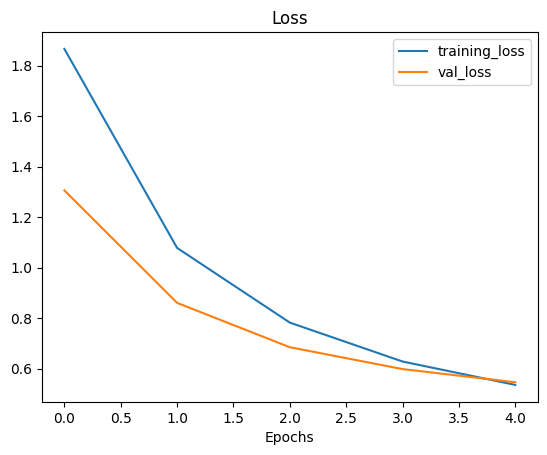

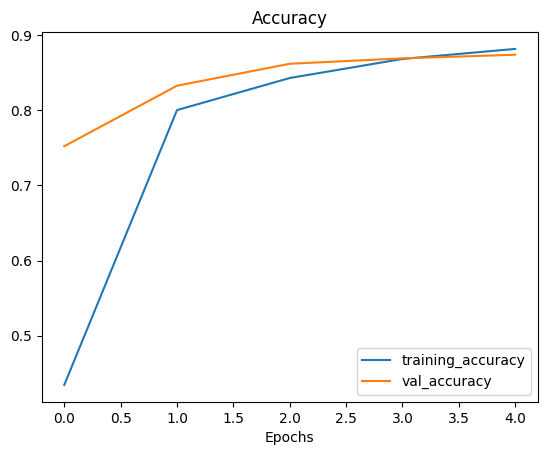

In [17]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model ##

Let's demonstrate the global average pooling 2d layer

We have a tensor after our model goes through the `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D it turns into (None,1280).  

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [18]:
#Define the input shape
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random Input Tensor:\n{input_tensor}\n")

#Pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2d global average pooled random tensor:\n {global_average_pooled_tensor} \n")

#Check the shape of the different tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2d tensor: {global_average_pooled_tensor.shape}")

Random Input Tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2d global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2d tensor: (1, 3)


In [19]:
#Let's replicate the Global Average Pooled 2D Layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🔨**Exercise:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

In [20]:
#Define the input shape
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random Input Tensor:\n{input_tensor}\n")

#Pass the random tensor through a global average pooling 2d layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2d global max pooled random tensor:\n {global_max_pooled_tensor} \n")

#Check the shape of the different tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global max pooled 2d tensor: {global_max_pooled_tensor.shape}")

Random Input Tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2d global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of global max pooled 2d tensor: (1, 3)


## Running a series of transfer learning experiments

WE've seen the incredible results transfer learning can get with only 10% of the training data, but how does it do with 1% of the training data.  How about we set up a bunch of experiments to find out.

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - upgrade our fine-tuning transfer learning experiment with 100% of the training data with data augmentation

> 🔑   Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.



In [21]:
#Download and unzip data - preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-11-08 04:35:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c03::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   135MB/s    in 0.9s    

2024-11-08 04:35:28 (135 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
#Create training and test_dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [23]:
#How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

## Getting a preprocessing data for model_1

In [24]:
# Setup data loaders
IMAGE_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMAGE_SIZE,
                                                                           batch_size=BATCH_SIZE) #default

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU instead of the CPU which is much faster
* Image data augmentation still happens only during training, so we can still export our whole model and use it elsewhere.


In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) #Keep for models like Resnet50V2 but EfficientNets have rescaling built in
], name="data_augmentation")

In [26]:
print(tf.__version__)

2.15.0


### Visualize our data augmentation layer (and see what happens to our data)

10_food_classes_1_percent/train/pizza/3042454.jpg


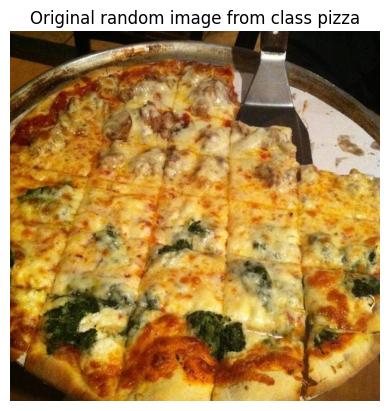

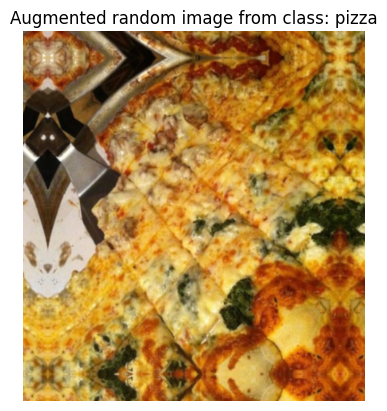

In [27]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" +random_image
print(random_image_path)

#Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);
#print(img)

#Now let's plot our augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(tf.squeeze(augmented_img/255.))
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1; feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup the input shape and base models, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)))

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 2.2952 - accuracy: 0.1000

In [ ]:
model_1.summary()

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

In [ ]:
# How do the model with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## View augmented data 10 percent

In [ ]:

# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_10_percent.class_names)
target_dir = "10_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" +random_image
print(random_image_path)

#Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);
#print(img)

#Now let's plot our augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(tf.squeeze(augmented_img/255.))
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 2; feature extraction transfer learning on 10% of the data with data augmentation

In [ ]:
# Make a model using the inputs and outputs
model_2 = keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fit the model
history_10_percent = model_2.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)))

In [ ]:
model_2.summary()

In [ ]:
# Evaluate model 2
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

In [ ]:
plot_loss_curves(history_10_percent)

### Creating a ModelCheckpoint Callback

The ModelCheckpoint Callback intermediately saves our model (the full model or just the weights) during training.  This is useful so we can come back and start where we left off.

In [ ]:
# Set CheckPoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves that model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)   #save every epoch

### Fit model 2 passing in the checkpoint model callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs=5


In [ ]:
history_10_percent_callback = model_2.fit(train_data_10_percent,
                                          batch_size=32,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=checkpoint_callback)

In [ ]:
#What were model 0 results?
model_0.evaluate(test_data)

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

In [ ]:
#plot model loss curves
plot_loss_curves(history_10_percent_callback)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
#Evaluate model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

In [ ]:
#If the results from our previously evaluated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

In [ ]:
results_10_percent_data_aug

In [ ]:
loaded_weights_model_results

In [ ]:
# Check to see if loaded model results are very close to our previously non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

## Model 3: Fine tuning an existing model on 10% of data

> 🔑 Note:  Fine tuning usually works best after training a feature extraction model for a few epochs with large amount of custom data.

In [ ]:
#Layers in our loaded model:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

In [ ]:
# To begin fine-tuning, let's begin by setting the last 10 layers of our base model trainable=True
base_model.trainable=True

# Freeze all layers except for last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile - we have to recompile our model every time we make a change
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), #When fine tuning, you typically want to lower the LR by x10
                metrics="accuracy")

# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

> 🔑 **Note:** When using fine-tuning, it's best practice to lower your LR by some amount.  How much?  This is a hyperparameter you can tune but a good rule of thumb is at least x10, though different sources will claim other values.
A good resouce for information on this is the ULM Fit paper: https://arxiv.org/abs/1801.06146

In [ ]:
# Now we've unfrozen some of the layers closer to the "top", how many trainable variables are there?
print(len(model_2.trainable_variables))
model_2.trainable_variables

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model 2 but with more trainable layers)

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                            epochs=fine_tune_epochs,
                                            validation_data=test_data,
                                            validation_steps=int(0.25*len(test_data)),
                                            initial_epoch=history_10_percent_callback.epoch[-1]) #start training from the previous last epoch

In [ ]:
# Evaluate the fine-tuned model 3 which is actually the fine-tuned model_2 for another 5 epochs
results_fine_tune_10_percent = model_2.evaluate(test_data)

In [ ]:
results_10_percent_data_aug

In [ ]:
# Check out the loss curves of our fine-tuned models
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
# The `plot_loss_curves` function works great with models that have only been fit once.  But we want to compare one series of running `fit` with another. (eg, before and after fine-tuning)

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs):
  '''
  COmpares two TensorFlow_history objects'''
  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine-Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine-Tuning")
  plt.legend(loc="lower left")
  plt.title("Training and Validation Loss")

In [ ]:
compare_histories(history_10_percent_callback,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

In [ ]:
## Model 4: Fine tuning an existing model on all the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

In [ ]:
#Setup training and test dirs
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE
                                                                                 )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

The test dataset we've loaded in the same dataset we've used for previous experiments.  All experiments have used the same test dataset.
Let's verify this...

In [ ]:
#Evaluate model 2 (this is the model fine-tuned on 10 of the data version)
model_2.evaluate(test_data)

In [ ]:
results_fine_tune_10_percent

To train a fine-tuning model (model 4) we need to revert model_2 back to its feature extraction weights.  

In [ ]:
# Load model from checkpoint (weights from checkpoint), that way we can fine tune from the same stage the 10-percent data model was fine-tuned from.
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

In [ ]:
# Check to see if our model_2 has been reverted to feature extraction results
results_10_percent_data_aug

Alright, the previous steps might seem quite confusing, but all we've done is:

1. Trained a feature extraction transfer learning model on 5 epochs on 10 percent of the data with data augmentation (model_2).  We've saved the model's weights using `ModelCheckpoint` callback.
2. We've fine-tuned the same model on the same 10 percent of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. We've saved the results and training logs each time.
4. We've reloaded the model from Step 1 to do the same steps as Step 2 except this time we're going to use all of the data (model_4).

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Let's drill into our base model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics="accuracy")

# Continue to train and fine-tune the model to our data (100% of the training data)
fine_tune_epochs = initial_epochs +5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_callback.epoch[-1]
                                           )

In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)

In [ ]:
# How did fine-tuning go with more data?
compare_histories(history_10_percent_callback,
                  history_fine_10_classes_full,
                  5)

In [ ]:
# Create a function to import our image and resize it to be able to be used with our model.
def load_and_prep_image(filename, img_shape=224):
  '''
  reads an image from filename, turns it into a tensor and reshapes
  it to (img_shape, img_shape, color_channels).
  '''
  #read in the image
  img=tf.io.read_file(filename)
  #decode the read file into a tensor
  img = tf.image.decode_image(img)
  #resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  #Rescale the image and get all values between 0 and 1
  img = img/255.
  return img



In [ ]:
def pred_and_plot(model, filename, class_names=train_data_10_classes_full.class_names):
  '''
  imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title
  '''
  #Import the target image and preprocess it
  img = load_and_prep_image(filename)
  print(img)

  #Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)

  #Get the predicted class
  #add in logic for multi-class & get pred class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]


  #Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

In [ ]:
#my_img = load_and_prep_image(filename="10_food_classes_all_data/test/chicken_curry/2480115.jpg")
#my_img
#model_2.predict(tf.expand_dims(my_img, axis=0))

pred_and_plot(model_2, filename="10_food_classes_all_data/test/chicken_curry/2480115.jpg")

In [ ]:
# View a random image and compare it to its augmented version
def visualize_from_any(dataset="train", target_class="steak"):
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  import os
  import random
  #target_class = random.choice(train_data_10_percent.class_names)
  #target_dir = "10_food_classes_all_data/train/" + target_class
  target_dir = "10_food_classes_all_data/" + dataset + "/" + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + "/" +random_image
  print(random_image_path)
  print(train_data_10_classes_full.class_names)

  #Read in the random image
  img = mpimg.imread(random_image_path)
  plt.imshow(img)
  plt.title(f"Original random image from dataset '{dataset}' and class '{target_class}'")
  plt.axis(False);
  #print(model_2.predict(random_image_path))
  #print(img)



In [ ]:
visualize_from_any(dataset="test", target_class="chicken_curry")

In [ ]:
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  import os
  import random

  target_dir = "10_food_classes_all_data/" + "train" + "/" + "hamburger"
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + "/" + random_image
  print(random_image_path)

  print(train_data_10_classes_full.class_names)
  pred_and_plot(model_2, random_image_path)